<a href="https://colab.research.google.com/github/meghla97/Review-Sentiment-Analysis-with-BERT-using-TensorFlow-and-Hugging-Face/blob/main/Hotel_Reviews_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment analysis of hotel reviews with BERT
Using some reviews I scraped and pulled through google translate for an Aspect Based Sentiment Analysis (ABSA) job, this notebook shows how to use a pretrained BERT model from Hugging Face to train a simple sentiment classifier using TensorFlow. The code contains all the necessary lines to use the full BERT model, but are commented out to use distilBERT instead, to speed up the finetuning job.

Looking for an approach using a custom training loop instead of the fit command?
https://colab.research.google.com/drive/1BSGF9Vcd76G22c_hNrJtt6UWfDFal5C7?usp=sharing



## Instal these packages

In [ ]:
!pip install "tensorflow >=2.0"
!pip install transformers
!pip install nltk
!pip install -q tf-models-official==2.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 37.4 MB/s 
     |████████████████████████████████| 120 kB 72.9 MB/s 
     |████████████████████████████████| 6.6 MB 21.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 37.7 MB/s 
     |████████████████████████████████| 352 kB 41.2 MB/s 
     |████████████████████████████████| 1.1 MB 46.0 MB/s 
     |████████████████████████████████| 1.3 MB 10.9 MB/s 
     |████████████████████████████████| 99 kB 8.1 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 238 kB 50.0 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import tensorflow as tf
from official import nlp
import official.nlp.optimization

from transformers import DistilBertTokenizer, TFDistilBertModel
from transformers import BertTokenizer, TFBertModel

from tensorflow.keras.layers import Dense, GlobalMaxPooling1D, Dropout, Input
from tensorflow.keras.models import Model

from tensorflow.data import AUTOTUNE

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import seaborn as sn

print("Version: ", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
if tf.config.list_physical_devices('GPU'):
  print(tf.config.list_physical_devices('GPU'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

Version:  2.8.2
GPU is available
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## I scraped a bunch of reviews from the web and placed them in my drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory = '/content/drive/My Drive/Sentiment/data/'
filename = 'reviews.csv'

df = pd.read_csv(directory + filename)

print(df.shape[0])
df.head()

105413


,rating,review
0,3.0,"This hotel was nice and quiet. Did not know, t..."
1,4.0,We stayed in the king suite with the separatio...
2,3.0,"Parking was horrible, somebody ran into my ren..."
3,5.0,Not cheap but excellent location. Price is som...
4,2.0,If you get the room that they advertised on th...


In [ ]:
df.isnull().values.any() # Check for NaN values in the dataframe

False

## We need to clean the data.
We're going to try some light cleaning, consisting of removing urls, ascii characters and lower casing the sentences, and some heavier cleaning, which adds the removal of stopwords using the NLTK stopwords.

In [ ]:
stop_words = set(stopwords.words('english'))

def PreProcessing(sentence, remove_stopwords=False):
  sentence = sentence.lower()
  sentence = re.sub("https*\S+", " ", sentence) # Remove urls
  sentence = sentence.encode('ascii', 'ignore').decode() # Remove ASCII characters
  #sentence = re.sub(r"\'t", " not", sentence) # Replace 't with not
  sentence = re.sub(r'([\^\#\@\;\:\|•«\n])', ' ', sentence) # remove some special characters
  sentence = re.sub('\s{2,}', " ", sentence) # Remove extra white spaces

  if remove_stopwords:
    words = sentence.split() # Split sentence into list of words
    words = [w for w in words if not w in stop_words] # Filter out stop words
    sentence = ' '.join(words)

  return sentence


In [ ]:
df['review_cleaned'] = df.review.apply(PreProcessing)
df['review_cleaned_wo_stopwords'] = df.review.apply(lambda x: PreProcessing(x, remove_stopwords=True))
print(df.review_cleaned.head(5))
print(df.review_cleaned_wo_stopwords.head(5))

0    this hotel was nice and quiet. did not know, t...
1    we stayed in the king suite with the separatio...
2    parking was horrible, somebody ran into my ren...
3    not cheap but excellent location. price is som...
4    if you get the room that they advertised on th...
Name: review_cleaned, dtype: object
0    hotel nice quiet. know, train track near by. t...
1    stayed king suite separation bedroom living sp...
2    parking horrible, somebody ran rental car stay...
3    cheap excellent location. price somewhat stand...
4    get room advertised website paid, may lucky.if...
Name: review_cleaned_wo_stopwords, dtype: object


## Divide data into train and validation sets before upsampling to avoid data leakage
We use a fixed random state (seed) when sampling the data before splitting it into the train-test sets. This is because, when you get kicked of Google Colab and want to continue finetuning your model later on, the dataset has to be preprocessed again. Without a fixed random state, this will generate a different train-test set each time, causing data leakage.

In [ ]:
random_state = 5 # Set random state to be used when sampling data

split = 0.8 # Set fraction of train-valid set
df = df.sample(frac=1, random_state=random_state) # Shuffle the dataframe before sampling train and valid sets to ensure equal distribution
train = df[:round(split*len(df))].reset_index(drop=True)
valid = df[round(split*len(df)):].reset_index(drop=True)
print(train.rating.value_counts(normalize=True)) # Check distribution train set
print(valid.rating.value_counts(normalize=True)) # Check distribution valid set

5.0    0.495636
4.0    0.268374
3.0    0.114811
2.0    0.062516
1.0    0.058662
Name: rating, dtype: float64
5.0    0.499739
4.0    0.272068
3.0    0.111417
2.0    0.060333
1.0    0.056444
Name: rating, dtype: float64


## Check the division of the classes
We're going to re-order the classes into negative(0) (1-2 stars), neutral(1) (3 stars) and positive(2) (4-5 stars). Furthermore, we're going to upsample the minority classes so that we don't have to drop data from the dominant classes.

In [ ]:
train.rating.value_counts() # Groups reviews by rating and counts them

5.0    41797
4.0    22632
3.0     9682
2.0     5272
1.0     4947
Name: rating, dtype: int64

In [ ]:
train.loc[:, 'rating_new'] = train.rating.replace(to_replace=(5, 4, 3, 2, 1), value=(2, 2, 1, 0, 0)).astype(int)
valid.loc[:, 'rating_new'] = valid.rating.replace(to_replace=(5, 4, 3, 2, 1), value=(2, 2, 1, 0, 0)).astype(int)

print(train.rating.head(5))
print(train.rating_new.head(5))
print(train.rating_new.value_counts())

0    4.0
1    3.0
2    5.0
3    5.0
4    2.0
Name: rating, dtype: float64
0    2
1    1
2    2
3    2
4    0
Name: rating_new, dtype: int64
2    64429
0    10219
1     9682
Name: rating_new, dtype: int64


In [ ]:
class0 = train.review_cleaned[train.rating_new==0]
class1 = train.review_cleaned[train.rating_new==1]
class2 = train.review_cleaned[train.rating_new==2]

In [ ]:
class0_upsampled = np.random.choice(class0, size=len(class2), replace=True)
class1_upsampled = np.random.choice(class1, size=len(class2), replace=True)
print(len(class0_upsampled))
print(len(class1_upsampled))

64429
64429


In [ ]:
def make_df(reviews, target):
  df_temp = pd.DataFrame(data={'rating': target*np.ones(len(reviews), dtype=np.int8), 'review': reviews}) #, columns=['rating', 'review'])
  return df_temp

# Create dataframes with concurrent target for each class
df_class0 = make_df(class0_upsampled, 0)
df_class1 = make_df(class1_upsampled, 1)
df_class2 = make_df(class2, 2)

# Concatenate classes, shuffle them and reset the index
train_final = pd.concat([df_class0, df_class1, df_class2], axis=0).sample(frac=1).reset_index(drop=True)

train_final.head(10)

,rating,review
0,0,n't stay arrived hotel huge honest little over...
1,0,extremely misleading hotel information mistake...
2,2,"very nice hotel, clean and well situated. we c..."
3,0,booked hotel rydges web site billy elliot capi...
4,2,lovely hotel 2 stars gives like 3 owner manage...
5,2,we drove in with no reservation and the staff ...
6,1,i booked the hotel room but i was surprised to...
7,0,our stay was overshadowed by checking in late ...
8,2,excellent hotel location excellent modern hote...
9,0,n't stay travel lot united states europe busin...


In [ ]:
x_train = train_final.review
#y_train = pd.get_dummies(train_final.rating)
y_train = train_final.rating.values
x_valid = valid.review
#y_valid = pd.get_dummies(valid.rating_new)
y_valid = valid.rating_new.values
y_valid

array([2, 1, 2, ..., 2, 0, 2])

## Choose max sentence length


0.9430898094543347

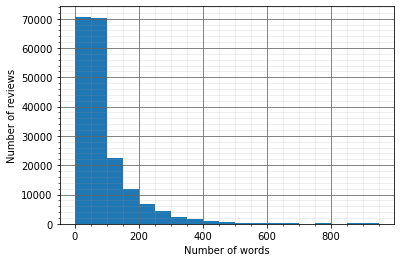

In [ ]:
reviews_len = [len(review.split()) for review in x_train] # Get a list containing the lengths of all reviews

bins = np.arange(0, 1000, 50) # Bins for histogram
plt.figure()
plt.hist(reviews_len, bins=bins)
plt.xlabel('Number of words')
plt.ylabel('Number of reviews')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

# The length of 94% of the reviews falls in 256 words. Do note that this does not
# mean that up to 256 words get inserted into the BERT model. This is because the
# tokenizer splits some words in multiple pieces, and also tokenizes interpunction.
percentage = len([review for review in reviews_len if review < 256]) / len(x_train)
percentage

## Get Tokenizer and tokenize data

In [ ]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
MAX_SEQUENCE_LENGTH = 256

testsentence = "Hi, this is a sentence to test the tokenizer. I'm curious what's about to happen!"

# As you can see, the tokenizer outputs more tokens than words present in the testsentence
encoded_input = tokenizer(testsentence, return_tensors='tf', max_length=MAX_SEQUENCE_LENGTH,
                          padding='max_length', add_special_tokens=True)
encoded_input

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

{'input_ids': <tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101,  7632,  1010,  2023,  2003,  1037,  6251,  2000,  3231,
         1996, 19204, 17629,  1012,  1045,  1005,  1049,  8025,  2054,
         1005,  1055,  2055,  2000,  4148,   999,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

In [ ]:
X_train = tokenizer(x_train.values.tolist(), return_tensors='tf', max_length=MAX_SEQUENCE_LENGTH,
                          padding='max_length', add_special_tokens=True, truncation=True)
X_valid = tokenizer(x_valid.values.tolist(), return_tensors='tf', max_length=MAX_SEQUENCE_LENGTH,
                          padding='max_length', add_special_tokens=True, truncation=True)

## Wrap the data in a tensorflow Dataset
We also shffle date data, cache it in memory, define batch size and prefetch data.

In [ ]:

BS = 6
train_ds = tf.data.Dataset.from_tensor_slices((X_train.data, y_train)).shuffle(1024).cache().batch(BS).prefetch(AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid.data, y_valid)).cache().batch(BS).prefetch(AUTOTUNE)
train_ds

<PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int8, name=None))>

## Create the model
Both BERT and distilBERT are implemented. Follow the instructions in the comments to decide which to use

In [ ]:
BERT_model = TFBertModel.from_pretrained("ProsusAI/finbert")

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


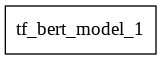

In [ ]:
tf.keras.utils.plot_model(BERT_model)

In [ ]:
BERT_model.summary()

Model: "tf_bert_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for layer in BERT_model.layers[-1].output:
  print(layer)

AttributeError: ignored

In [ ]:
BERT_model.layers[-1]


In [ ]:
def create_model():
    '''
    The first token of every sequence is always a special classification token ([CLS]).
    The final hidden state corresponding to this token is used as the aggregate
    sequence representation for classification tasks. BERT paper: https://arxiv.org/pdf/1810.04805.pdf
    '''

    #BERT_model = TFBertModel.from_pretrained("bert-base-uncased") # BERT
    distilBERT_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased") # distilBERT

    input_id = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
    input_mask = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')
    #token_type = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='token_type_ids') # Uncomment this when using BERT instead of distilBERT

    ## Uncomment this when using BERT instead of distilBERT
    #embedding = BERT_model([input_id, token_type, input_mask])[1] # BERT has 2 outputs, grab the pooled output, which is the [CLS] token output
    #x = Dropout(0.2)(embedding)
    #x = Dense(768, activation='relu')(embedding) # BERT
    #x = Dropout(0.2)(x) # BERT

    ## Uncomment this when using distilBERT instead of BERT
    embedding = distilBERT_model([input_id, input_mask])
    last_hidden_state_cls = embedding.last_hidden_state[:,0,:] # Select the last hidden state, and use the output embedding of the first token [CLS] for classification
    x = Dropout(0.2)(last_hidden_state_cls)
    x = Dense(768, activation='relu')(x)
    x = Dropout(0.2)(x)

    ## Softmax classification layer
    x = Dense(3, activation='softmax')(x)

    ## Uncomment when using BERT:
    #model = Model(inputs=[input_id, token_type, input_mask], outputs=x)

    ## Uncomment when using distilBERT:
    model = Model(inputs=[input_id, input_mask], outputs=x)

    return model

In [ ]:
print('Creating model..')
model = create_model()

Creating model..


Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


## Some visualizations of the model

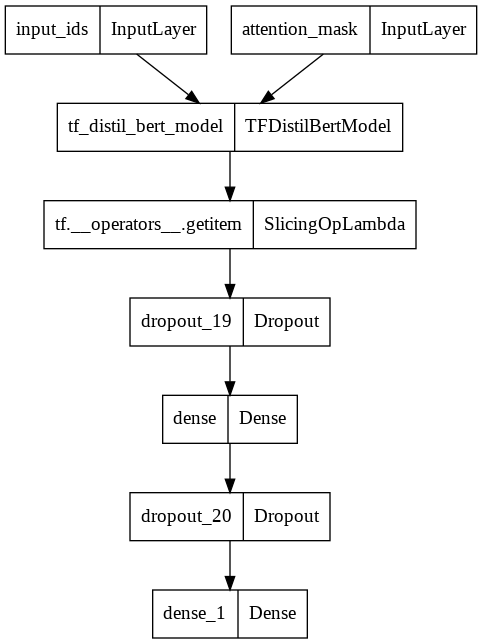

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 256, 768),                                                   
                                 hidden_states=None                                           

In [ ]:
'''
If you don't want to train the BERT parameters, you can freeze the BERT layer.
This way only the added layers will be trained for the classification problem.
'''
## For distilBERT, freeze layer 2. For BERT, freeze layer 3. You can also print
## the summary again to see the new number of trainable parameters.
#model.layers[3].trainable = False
#model.summary()

"\nIf you don't want to train the BERT parameters, you can freeze the BERT layer. \nThis way only the added layers will be trained for the classification problem.\n"

## Checkpoint
Use the checkpoint callback to save a copy of the model weights after each epoch. This is especially handy on Google Colab because it likes to kick you off the vm in the middle of training when you're training large models.

In [ ]:

#checkpoint_path = "/content/drive/My Drive/Sentiment/save_models/cp.ckpt"
checkpoint_path = "/content/drive/My Drive/Sentiment/save_model_distil/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

## Optimizer, metrics and loss function
Set these up and compile the model

In [ ]:
# Set up epochs and steps
epochs = 1
batch_size = BS # Set this so that it fits on the GPU

train_data_size = len(x_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

## Creates an optimizer with learning rate schedule, using warmup steps and
## weight decay (AdamWeightDecay)
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
## Use sparse when the classes are not one hot encoded
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) # False when the output is a probability, like when using softmax

## Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Train the model
Optionally, load the weights from a checkpoint. Use this when Colab kicked you off the vm and a checkpoint was saved.

In [ ]:
## Uncomment this if you want to load the weights from a checkpoint
model.load_weights(checkpoint_path)

In [ ]:
## Train the model while feeding the data as tf.data.Dataset
history = model.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=[cp_callback])

32215/32215 [==============================] - ETA: 0s - loss: 0.2568 - accuracy: 0.9318
Epoch 1: saving model to /content/drive/My Drive/Sentiment/save_model_distil/cp.ckpt
32215/32215 [==============================] - 12343s 383ms/step - loss: 0.2568 - accuracy: 0.9318 - val_loss: 0.7076 - val_accuracy: 0.8447


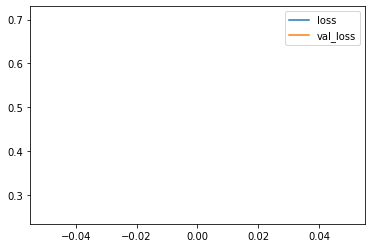

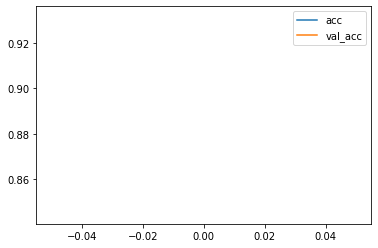

In [ ]:
## Plot the loss and the accuracy for each epoch during training.
## As Google kicked me off the vm after every epoch, this doesn't hold a lot of
## information.
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

## Get predictions and use them to evaluate the model

In [ ]:
p = model.predict(valid_ds)

In [ ]:
y_valid_dummies = pd.get_dummies(y_valid).values # One hot encode target
aucs = []
for j in range(3):
    auc = roc_auc_score(y_valid_dummies[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.912567185027454


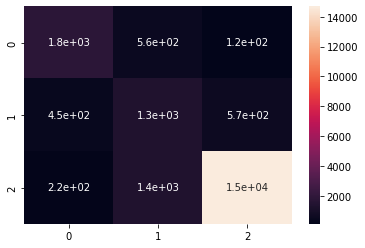

In [ ]:
cf_matrix = confusion_matrix(y_valid_dummies.argmax(axis=1), p.argmax(axis=1))
df_cm = pd.DataFrame(cf_matrix, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure()
sn.heatmap(df_cm, annot=True)

In [ ]:
class_rep = classification_report(y_valid_dummies.argmax(axis=1), p.argmax(axis=1))
print(class_rep)

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2462
           1       0.41      0.56      0.47      2349
           2       0.96      0.90      0.93     16272

    accuracy                           0.84     21083
   macro avg       0.70      0.73      0.71     21083
weighted avg       0.87      0.84      0.85     21083



## Discussion
We can see that the negative and neutral classes are not predicted very accurately. The model still achieves an accuracy of 84%, but this is mainly because the positive class has a high precision and recall and makes up about 77% of the validation set.

Some ideas to get better results:


1.   Get more data, like always.
2.   Try keeping the original 5 classes during training, and pool them into positive, negative and neutral after training and prediction.
3. I only trained for 2 epochs in this notebook. Try to train for more and implement an 'early stopping' callback.
4. Use BERT instead of distilBERT.
4. Train the model with stopwords removed from the reviews. This has already been implemented in the code above, but hasn't been used.

